# Minecraft Skill Data

[Датасет](https://huggingface.co/datasets/dami2106/Minecraft-Skill-Data)

Доступно только разделение по трейну. Просто через load_dataset его скачать. К сожалению, ссылка на гит проекта нерабочая, так что какие-то аспекты датасета придётся додумывать и интерпретировать самостоятельно.

## Описание из ридми

В ридми сказано, что геймплей записан при помощи экспертной стратегии. В каждом эпизоде есть разметка используемого навыка (сам навык и его границы использования). Автор предлагает использовать этот датасет для обучения модели сегментировать долгосрочное поведение в переиспользуемые навыки.

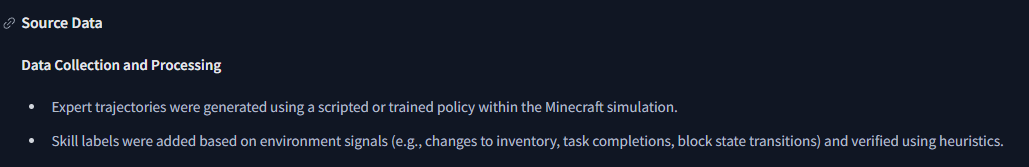

Также потенциально можно его использовать для обучению задач на основе естественного языка (но такой разметки в данных нет)

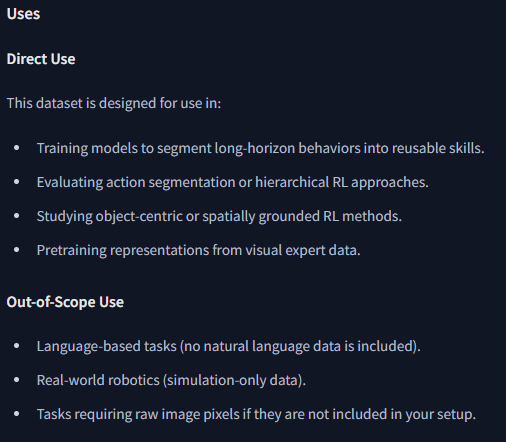

Структура каждой папок датасета

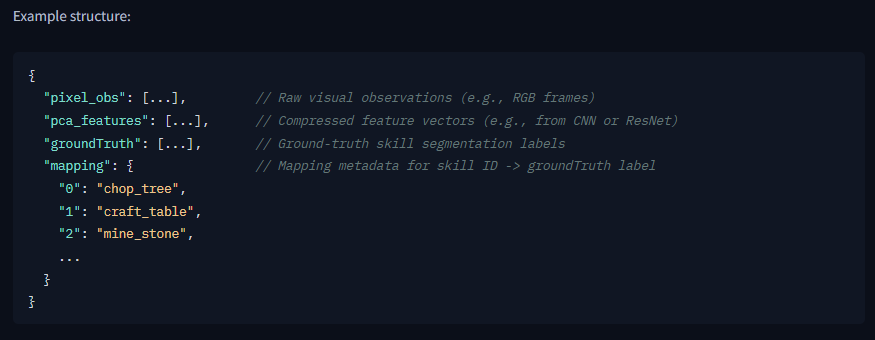

In [1]:
from huggingface_hub import snapshot_download

local_dir = snapshot_download(
    repo_id="dami2106/Minecraft-Skill-Data",
    repo_type="dataset",
)

print(local_dir)

Fetching ... files: 0it [00:00, ?it/s]

/hf_cache/hub/datasets--dami2106--Minecraft-Skill-Data/snapshots/9ecaeb3a6ddb00482fd5f2080d97db7573453ac7


Посмотрим, какие есть навыки

In [2]:
import os 

print(os.listdir(local_dir))

['.gitattributes', 'cobblestone', 'iron_ingot', 'README.md', 'stone_pickaxe', 'wooden_pickaxe']


Скорее всего эти папки отвечают за получение названного ресурса, посмотрим на cobblestone

In [4]:
cobble_path = os.path.join(local_dir, 'cobblestone')

print(os.listdir(cobble_path))

['groundTruth', 'mapping', 'observations', 'pca_features', 'pca_groundTruth', 'pca_stats.json', 'reconstruction_comparison.pdf', 'stats.json', 'trace_config.json']


### JSON файлы

Посмотрим сперва на них

In [9]:
import json

def print_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
        print(json.dumps(data, indent=2, ensure_ascii=False))
        f.close()

In [6]:
print_json(os.path.join(cobble_path, "pca_stats.json"))

{
  "args": {
    "data_dir": "Data/cobblestone",
    "frame_freq": 6
  },
  "pca_components": 4000,
  "explained_variance_ratio": [
    0.24090887606143951,
    0.14140328764915466,
    0.05598822608590126,
    0.04880071058869362,
    0.03667208552360535,
    0.03386994078755379,
    0.028080996125936508,
    0.01916271634399891,
    0.01666194573044777,
    0.01295651588588953,
    0.011203048750758171,
    0.010549405589699745,
    0.00899791531264782,
    0.008366688154637814,
    0.007077987305819988,
    0.0065184603445231915,
    0.0060140821151435375,
    0.005587499123066664,
    0.005157149862498045,
    0.004787588957697153,
    0.0045165810734033585,
    0.004404839128255844,
    0.004038237035274506,
    0.003682780545204878,
    0.0036165870260447264,
    0.003352252533659339,
    0.003072821069508791,
    0.0028351217042654753,
    0.002727205166593194,
    0.0025554115418344736,
    0.002461914671584964,
    0.0023558244574815035,
    0.0022619592491537333,
    0.00216

Используется 4000 признаков и ещё какая-то часть всё же отсеяна, раз суммарная объяснённая дисперсия меньше единицы. Заодно можно показать пример реконструкции, который хранится в датасете

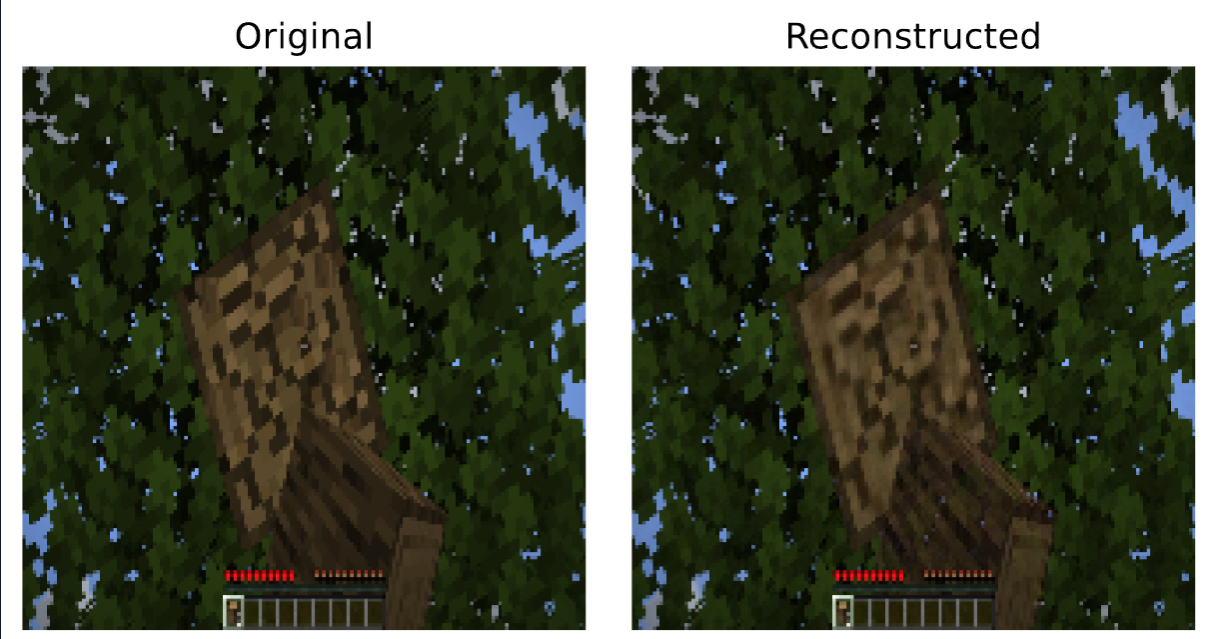

Разницы практически нет, так что можно отсечь и больше признаков

Ещё здесь приведён frame_freq=6, видимо данные пишутся с частотой 6 кадров в секунду

Посмотрим на другие статистики

In [7]:
print_json(os.path.join(cobble_path, "stats.json"))

{
  "total_episodes": 100,
  "unique_skills": 8,
  "min_episode_length": 613,
  "avg_episode_length": 754.52,
  "max_episode_length": 988,
  "ground_truth_distribution": {
    "log": 39034,
    "planks": 3511,
    "crafting_table": 6899,
    "stick": 5519,
    "wooden_pickaxe": 9652,
    "dirt": 10709,
    "cobblestone": 99,
    "coal": 29
  }
}


То есть внутри эпизода ещё фиксируются используемые навыки

In [8]:
print_json(os.path.join(cobble_path, "trace_config.json"))

{
  "parameters": {
    "weights": "rl-from-early-game-2x.weights",
    "model": "2x.model",
    "target_item": "cobblestone",
    "max_steps": 1000,
    "episodes": 100,
    "save_dir": "Data/cobblestone"
  }
}


Ссылок на модель или веса в датасете нет

Теперь пройдёмся по папкам

### Mapping

In [10]:
mapping_path = os.path.join(cobble_path, 'mapping', 'mapping.txt')

with open(mapping_path) as f:
    lines = f.readlines()
    f.close()
    
print(lines)

['0 log\n', '1 planks\n', '2 crafting_table\n', '3 wooden_pickaxe\n', '4 dirt\n', '5 cobblestone\n', '6 coal\n', '7 stick']


Это закодированные в числа навыки

0. log
1. planks
2. crafting_table
3. wooden_pickaxe
4. dirt
5. cobblestone
6. coal
7. stick

Кстати, в каждой глобальной папке (cobblestone, iron_ingot и пр.) свой набор навыков, вот такой вот в iron_ingot

0. crafting_table
1. cobblestone
2. coal
3. torch
4. furnace
5. stone_pickaxe
6. dirt
7. iron_ore
8. stick
9. planks
10. iron_ingot
11. log
12. wooden_pickaxe
13. stone_shovel

при этом на одни и те же навыки кодировка **отличается**

### Ground Truth

Здесь лежат файлы с разметками для каждого из примеров

In [11]:
gt = os.path.join(cobble_path, "groundTruth")

print(len(os.listdir(gt)))

100


100 примеров, так как 100 эпизодов, откроем первый пример

In [18]:
import numpy as np
example_name = os.listdir(gt)[0]
print(example_name)
example_path = os.path.join(gt, example_name)

with open(example_path, 'r') as f:
    lines = f.readlines()
    f.close

print(lines)
print(len(lines))


minecraft_1
['log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n

То есть тут просто разметка по навыкам внутри одного эпизода

### Observations

In [ ]:
obs_root = os.path.join(cobble_path, "observations")

print(len(os.listdir(obs_root)))

100


In [20]:
example_name = os.listdir(obs_root)[0]
print(example_name)
example_path = os.path.join(obs_root, example_name)

obs = np.load(example_path)

print(obs.shape)

minecraft_1.npy
(687, 160, 160, 3)


Здесь хранятся RGB изображения размера 160x160. Выведем примеры

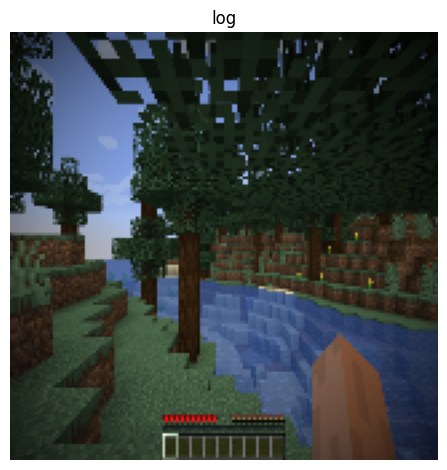

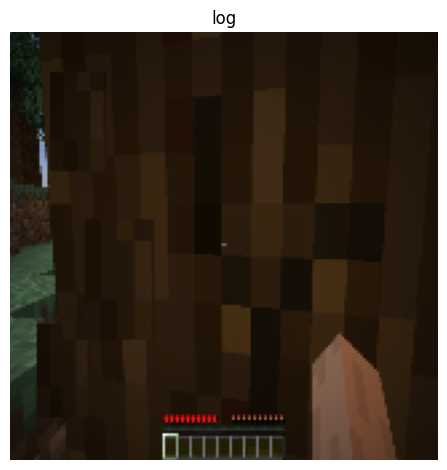

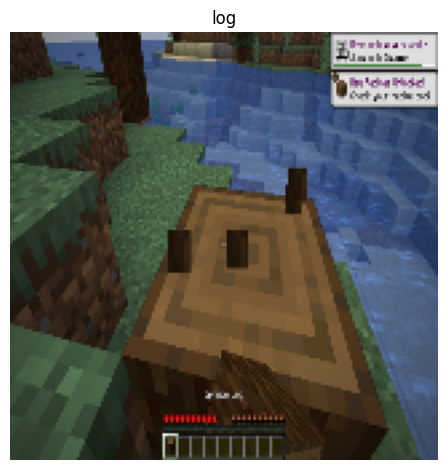

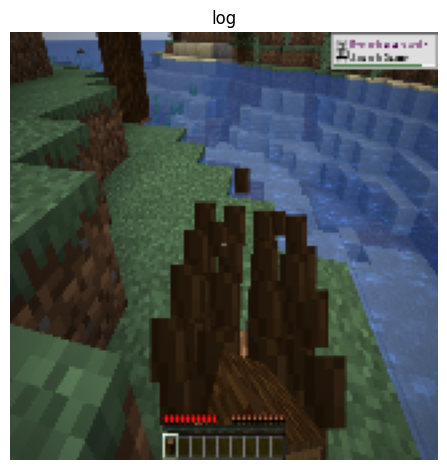

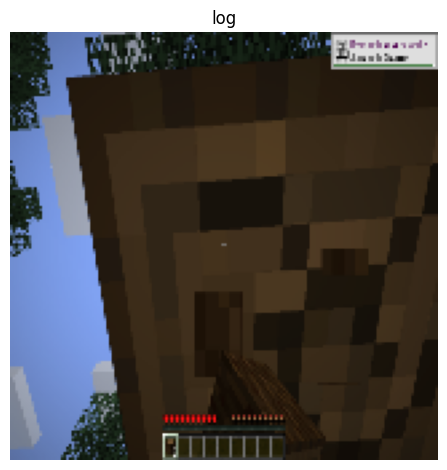

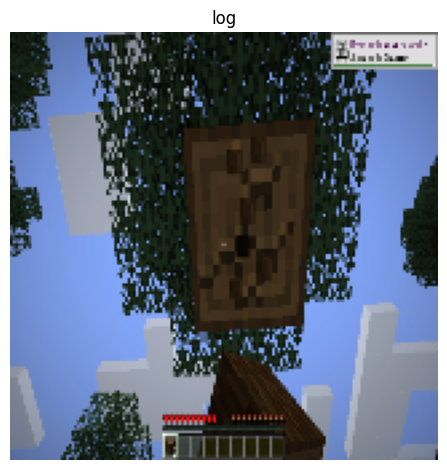

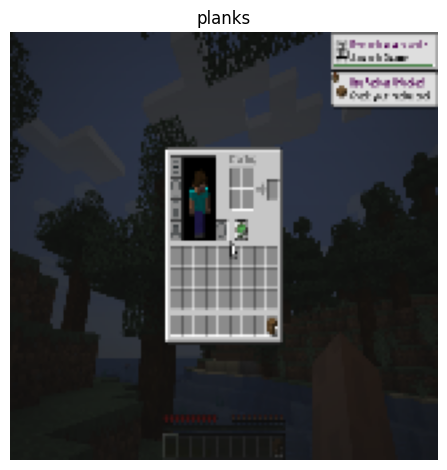

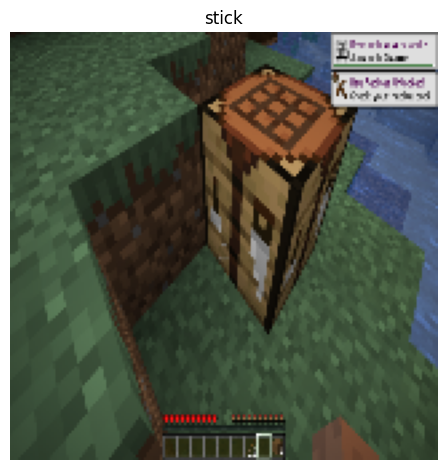

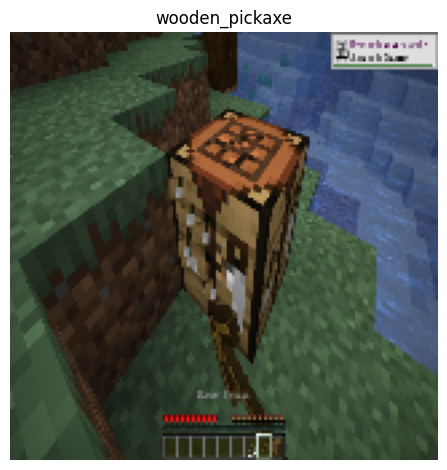

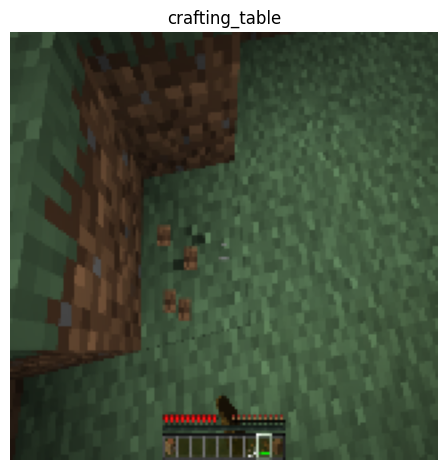

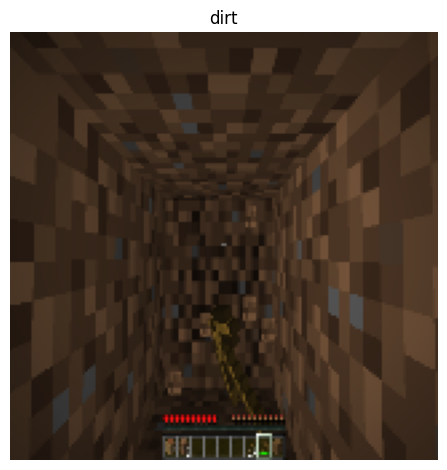

In [26]:
import matplotlib.pyplot as plt

for i in range(0, obs.shape[0], 64):
    plt.figure()
    plt.title(lines[i][:-1])
    img = obs[i]
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

### PCA

Тут есть pca_features и pca_groundTruth

In [27]:
features_root = os.path.join(cobble_path, 'pca_features')
print(len(os.listdir(features_root)))
example_name = os.listdir(features_root)[0]
print(example_name)
example_path = os.path.join(features_root, example_name)

features = np.load(example_path)

print(features.shape)

100
minecraft_1.npy
(116, 4000)


По идее по описанию датасета эти признаки должны соответствовать выделенным признакам из изображения через ResNet модель

Вот так выглядит pca gt

In [28]:
groundTruth_root = os.path.join(cobble_path, 'pca_groundTruth')
print(len(os.listdir(groundTruth_root)))
example_name = os.listdir(groundTruth_root)[0]
print(example_name)
example_path = os.path.join(groundTruth_root, example_name)

with open(example_path, 'r') as f:
    lines = f.readlines()
    f.close

print(lines)
print(len(lines))

100
minecraft_1
['log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'log\n', 'planks\n', 'planks\n', 'planks\n', 'planks\n', 'planks\n', 'crafting_table\n', 'crafting_table\n', 'crafting_table\n', 'crafting_table\n', 'crafting_table\n', 'stick\n', 'stick\n', 'stick\n', 'stick\n', 'stick\n', 'stick\n', 'stick\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n', 'wooden_pickaxe\n',

Не ясно за что отвечает число 116, потому что оно не сходится с длиной эпизода. Мы везде брали файлы из одного эпизода, это можно проверить по названиям файлов, которые были выведены

## Вывод

Этот датасет можно использовать для обучения визуальной модели, чтобы она определяла предмет, который добывается агентом. Только надо делать правильный ресайз изображений под общий формат. Правда число предметов, которые можно выучить таким образом, довольно ограничено. Посмотрим на все уникальные предметы в датасете

In [30]:
dirs = os.listdir(local_dir)
res = []
for folder in dirs:
    if "." in folder:
        continue
    mapping = os.path.join(local_dir, folder, 'mapping', 'mapping.txt')
    with open(mapping, 'r') as f:
        lines = f.readlines()
        items = [line.split(" ")[1].strip('\n') for line in lines]
        f.close()
    res = res + items
    
res = set(res)

print(res)
print(len(res))

{'cobblestone', 'stone_shovel', 'iron_ingot', 'coal', 'dirt', 'planks', 'stick', 'torch', 'furnace', 'stone_pickaxe', 'iron_ore', 'crafting_table', 'log', 'wooden_pickaxe'}
14


Такой датасет может пригодиться для выполнения задачи добычи железного слитка. Правда пока у меня нет идей, как это конвертировать именно в постановку задачи добычи железа. Всё же в этом датасете агент может только распознать добываемый объект, он не выучит последовательность действий для выполнения задачи.